In [1]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(0)

In [2]:
# Mount drive to access files
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/NPB 198 Final Project

Mounted at /content/drive
/content/drive/My Drive/NPB 198 Final Project


# Stage 1: Data Loading/Organization

In [3]:
# Extract output data from IS/ISA/CAN/HAS data csv's into dataframes
is_output = pd.read_csv("sem rep IS data.csv", delimiter=",", header=0, index_col=0)
isa_output = pd.read_csv("sem rep ISA data.csv", delimiter=",", header=0, index_col=0)
can_output = pd.read_csv("sem rep CAN data.csv", delimiter=",", header=0, index_col=0)
has_output = pd.read_csv("sem rep HAS data.csv", delimiter=",", header=0, index_col=0)

In [4]:
# Extracts lists of animals and attributes from dataframes
animals_list = is_output.index.values
attributes_list = is_output.columns.values

# Create list of relation names
relations_list = ["IS", "ISA", "CAN", "HAS"]

In [5]:
# Turn dataframes into tensors for outputs
is_output_numpy = is_output.to_numpy()
isa_output_numpy = isa_output.to_numpy()
can_output_numpy = can_output.to_numpy()
has_output_numpy = has_output.to_numpy()

In [6]:
# Make lists of animal and relation inputs

animal_inputs = [[1,0,0,0,0,0,0,0], # grizzly bear
                [0,1,0,0,0,0,0,0], # black bear
                [0,0,1,0,0,0,0,0], # bald eagle
                [0,0,0,1,0,0,0,0], # golden eagle
                [0,0,0,0,1,0,0,0], # salmon
                [0,0,0,0,0,1,0,0], # trout
                [0,0,0,0,0,0,1,0], # caribou
                [0,0,0,0,0,0,0,1]] # moose

relation_inputs = [[1,0,0,0], # IS
                  [0,1,0,0], # ISA
                  [0,0,1,0], # CAN
                  [0,0,0,1]] # HAS

In [7]:
# Stuff inputs and outputs for each relation into lists of tuples
# Then combine them into DataLoaders
# Format of data: ((Animal input, relation input), relation-specific output)

is_IO = []
for i in range(8):
  is_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[0]).float()),
      torch.tensor(is_output_numpy[i]).float())
      )

isa_IO = []
for i in range(8):
  isa_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[1]).float()),
      torch.tensor(isa_output_numpy[i]).float())
      )
  
can_IO = []
for i in range(8):
  can_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[2]).float()),
      torch.tensor(can_output_numpy[i]).float())
      )
  
has_IO = []
for i in range(8):
  has_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[3]).float()),
      torch.tensor(has_output_numpy[i]).float())
      )

all_IO = is_IO + isa_IO + can_IO + has_IO

is_IO_DataLoader = DataLoader(is_IO, batch_size=1, shuffle=False)
isa_IO_DataLoader = DataLoader(isa_IO, batch_size=1, shuffle=False)
can_IO_DataLoader = DataLoader(can_IO, batch_size=1, shuffle=False)
has_IO_DataLoader = DataLoader(has_IO, batch_size=1, shuffle=False)
all_IO_DataLoader = DataLoader(all_IO, batch_size=1, shuffle=True)

In [8]:
# Sets order of relation dataloaders for testing each relation
relation_DL_order = [is_IO_DataLoader,
                     isa_IO_DataLoader,
                     can_IO_DataLoader,
                     has_IO_DataLoader]

# Stage 2: Network Setup

In [9]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(8, 8) # representation layer
    self.fc2 = nn.Linear(12, 15) # hidden layer
    self.fc3 = nn.Linear(15, 40) # attribute layer

    # Initialize weights and biases for all layers
    torch.nn.init.uniform_(self.fc1.weight, a=-0.9, b=0.9)
    torch.nn.init.uniform_(self.fc2.weight, a=-0.9, b=0.9)
    torch.nn.init.uniform_(self.fc3.weight, a=-0.9, b=0.9)
    torch.nn.init.zeros_(self.fc1.bias)
    torch.nn.init.zeros_(self.fc2.bias)
    torch.nn.init.zeros_(self.fc3.bias)
  
  def forward(self, data):
    # Extract animal/relation inputs from "data" tuple
    # x = animal, y = relation
    x, y = data

    # Animal input to representation layer, save representation data in var
    fc1 = self.fc1(x)
    x = torch.sigmoid(fc1)

    # Concatenate rep layer output and relation input
    combined = torch.cat((x, y), dim=1)

    # Send concatenated input to hidden layer
    fc2 = self.fc2(combined)
    x = torch.sigmoid(fc2)

    # Hidden layer to attribute layer
    fc3 = self.fc3(x)
    output = torch.sigmoid(fc3)
    return output

# Stage 3: Training and Testing

In [10]:
# Set learning rate, momentum, and num of epochs
learning_rate = 0.1
momentum = 0
num_epochs = 3500

# Make network and set up optimizer for backpropagation
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=0)

In [11]:
# Set up function for extracting representation layer data
def get_hidden_features(x, layer):
    activation = {}

    def get_activation(name):
        def hook(network, input, output):
          activation[name] = output.detach()
        return hook

    rep_list = []
    hook = network.fc1.register_forward_hook(get_activation(layer))
    passthru = network(x)
    rep_list.append(activation[layer])
    hook.remove()
    return rep_list[0]

In [12]:
# Set up function for network training
def train(epoch):
  network.train()
  train_loss = 0

  # Iterate over each of the 4 relation datasets during training
  for data, target in all_IO_DataLoader:
    output = network(data)
    loss = nn.CrossEntropyLoss()
    loss_amount = loss(output, target)
    train_loss += loss_amount

    optimizer.zero_grad()
    loss_amount.backward()
    optimizer.step()

  # Print out training progress for each relation dataset every 350 epochs
  train_loss /= len(all_IO_DataLoader)
  if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
    print("Train Epoch {}: \tLoss: {:.6f}".format(
      epoch, train_loss))

In [13]:
# Set up function for testing
def test(epoch):
  network.eval()

  with torch.no_grad():
    if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
      for i in range(4):
        test_loss = 0

        for index, (data, target) in enumerate(relation_DL_order[i]):
          output = network(data)
          loss = nn.CrossEntropyLoss()
          test_loss += loss(output, target)

        test_loss /= len(relation_DL_order[i])
        print("Test: {}\tAverage loss = {:.6f}".format(relations_list[i], 
                                                      test_loss))  

In [14]:
# Create list of values for representation data
rep_values_list = []

# Create bar graphs of animal representation data
def create_rep_graphs(epoch):
  with torch.no_grad():
    fig, ax = plt.subplots(8, sharex=True, figsize=(6,24))
    fig.suptitle(f"Animal Representation Data, Epoch {epoch}", y=0.905)
    for index, (data, target) in enumerate(relation_DL_order[0]):
      labels = np.arange(8)
      values = get_hidden_features(data, 'fc1')
      values = values.numpy()[0]
      if epoch == num_epochs:
        rep_values_list.append(values)
      ax[index].bar(labels, values)
      ax[index].set_title(animals_list[index].upper())

Train Epoch 1: 	Loss: 11.449574
Test: IS	Average loss = 7.170148
Test: ISA	Average loss = 18.473454
Test: CAN	Average loss = 11.401970
Test: HAS	Average loss = 8.373704


Train Epoch 175: 	Loss: 9.520413
Test: IS	Average loss = 5.973455
Test: ISA	Average loss = 16.140877
Test: CAN	Average loss = 8.645121
Test: HAS	Average loss = 7.297243


Train Epoch 350: 	Loss: 9.269469
Test: IS	Average loss = 5.812594
Test: ISA	Average loss = 15.537449
Test: CAN	Average loss = 8.558508
Test: HAS	Average loss = 7.149580


Train Epoch 525: 	Loss: 9.151893
Test: IS	Average loss = 5.708591
Test: ISA	Average loss = 15.294174
Test: CAN	Average loss = 8.520450
Test: HAS	Average loss = 7.077479


Train Epoch 700: 	Loss: 9.091587
Test: IS	Average loss = 5.653894
Test: ISA	Average loss = 15.195068
Test: CAN	Average loss = 8.509356
Test: HAS	Average loss = 7.002922


Train Epoch 875: 	Loss: 9.047997
Test: IS	Average loss = 5.558372
Test: ISA	Average loss = 15.153061
Test: CAN	Average loss = 8.504522
Test: HAS	

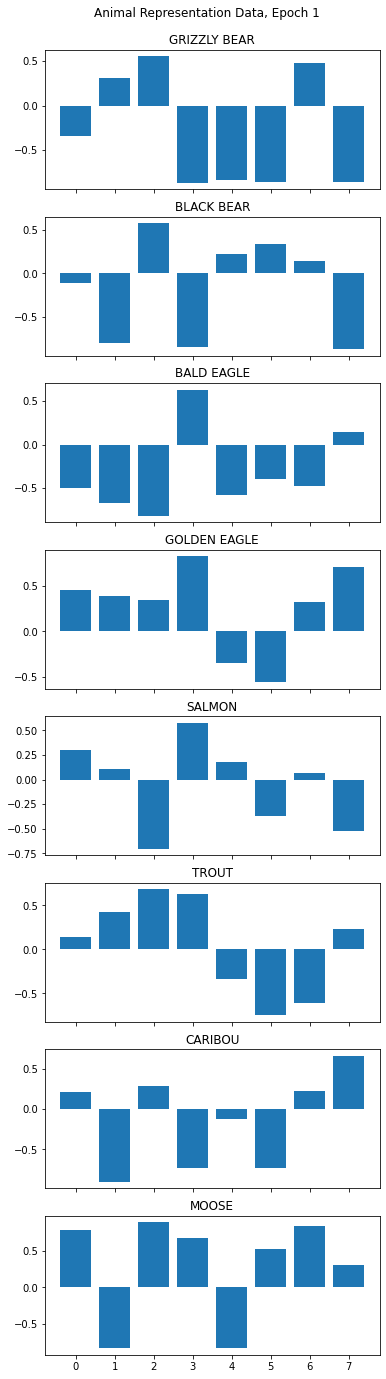

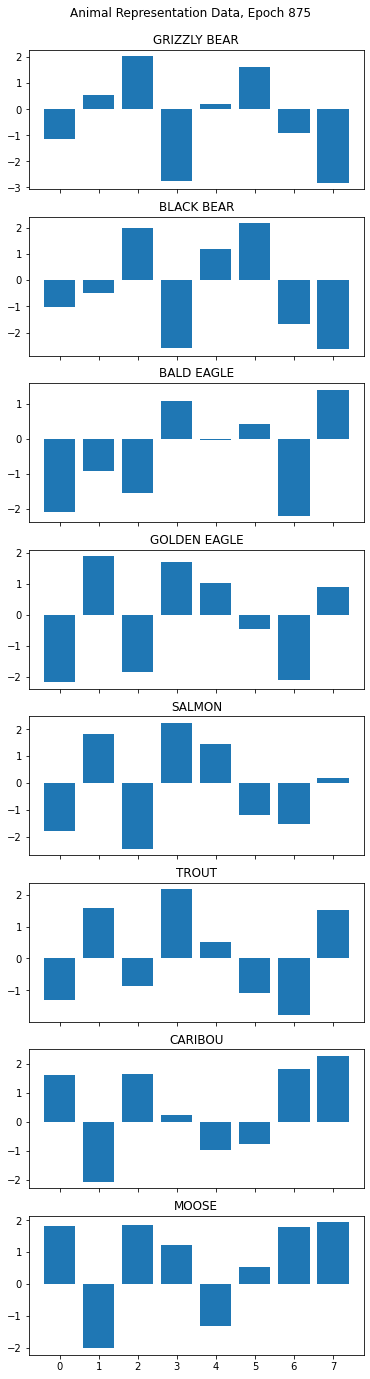

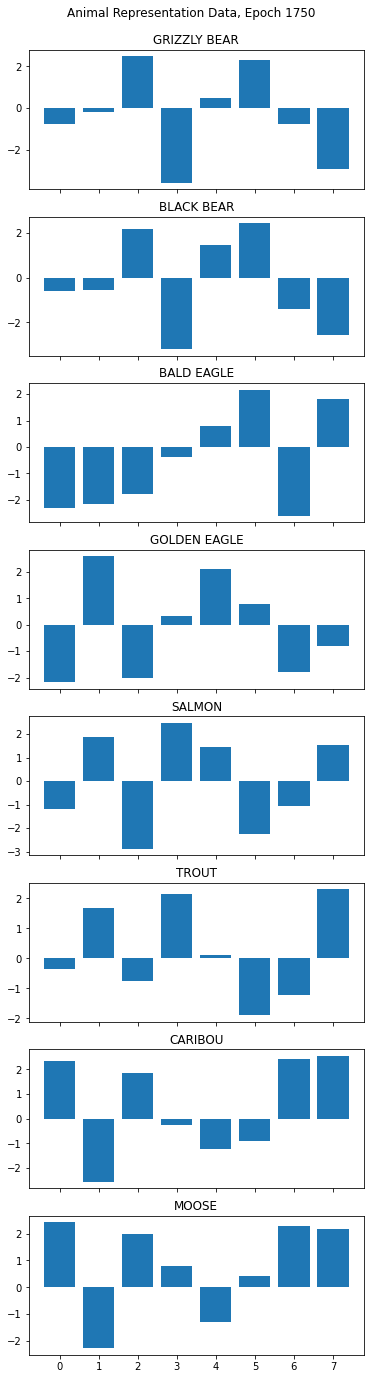

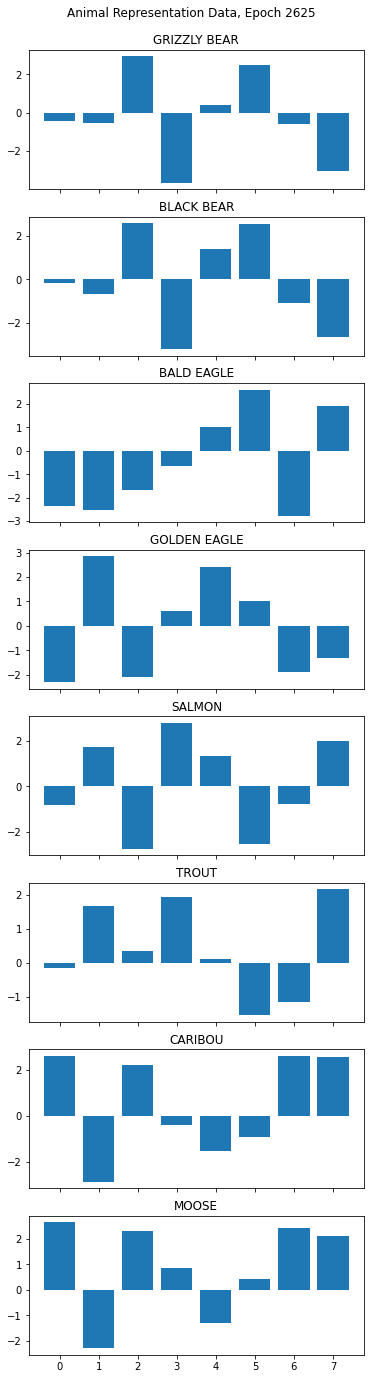

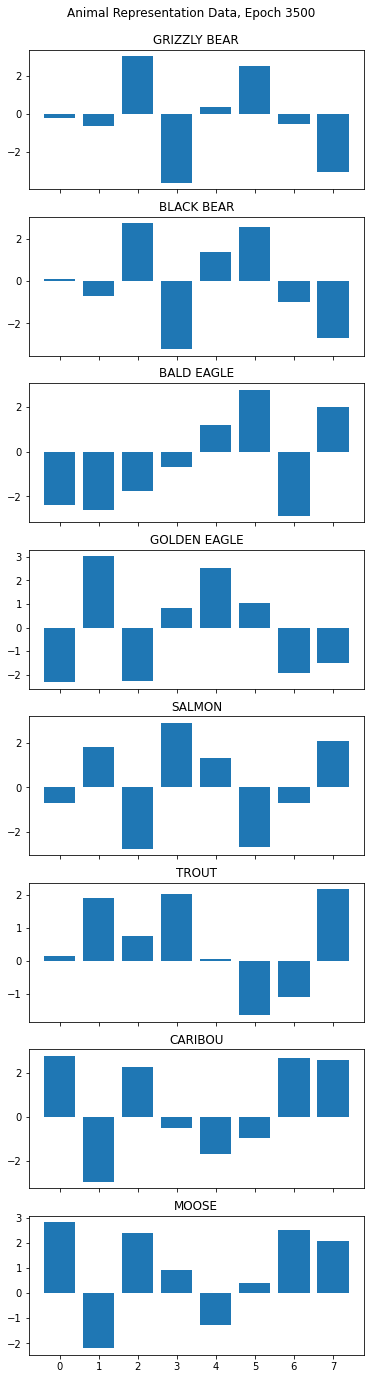

In [15]:
# Commence training and testing
for epoch in range(1, num_epochs + 1):
  train(epoch)
  test(epoch)
  if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
    print("\n")
  if (epoch == 1) or (epoch % (num_epochs // 4) == 0):
    create_rep_graphs(epoch)

Results for IS:


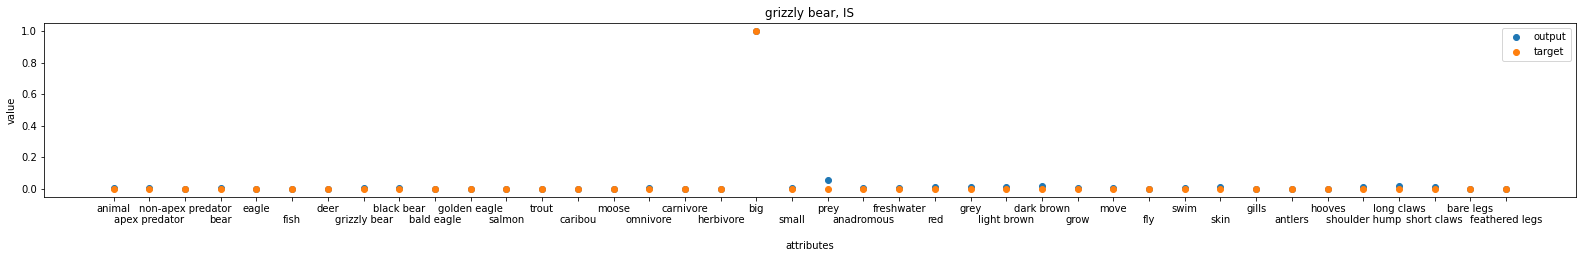

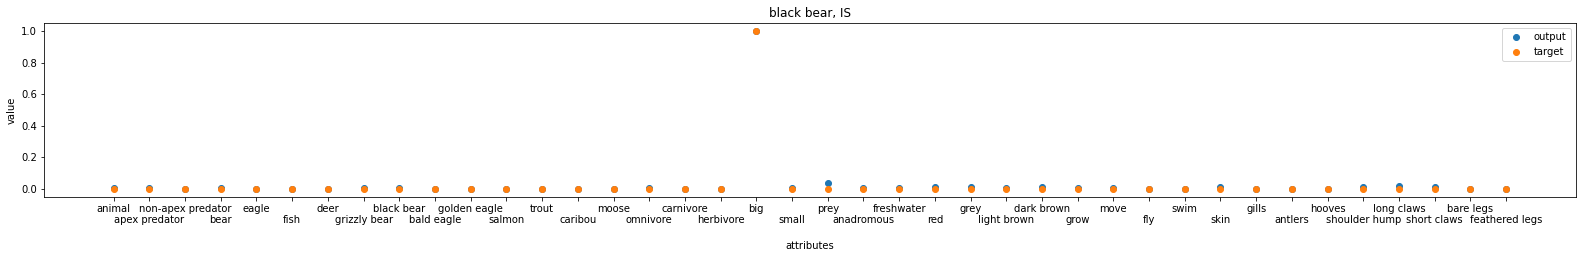

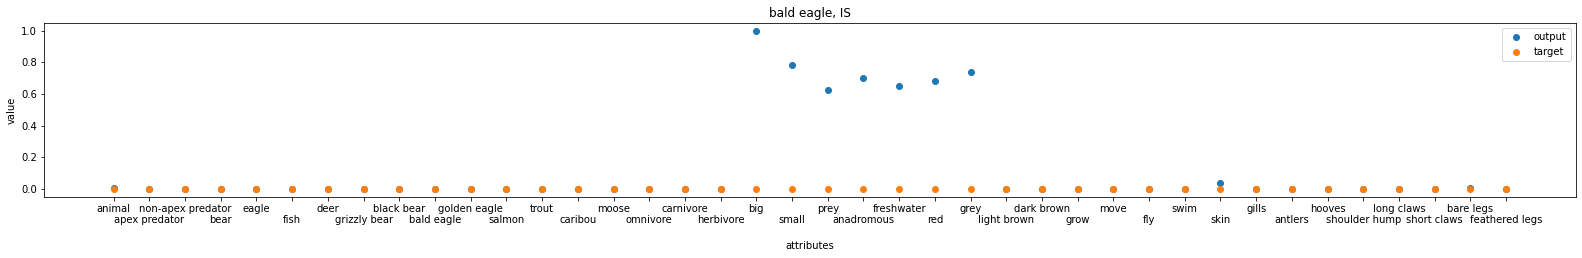

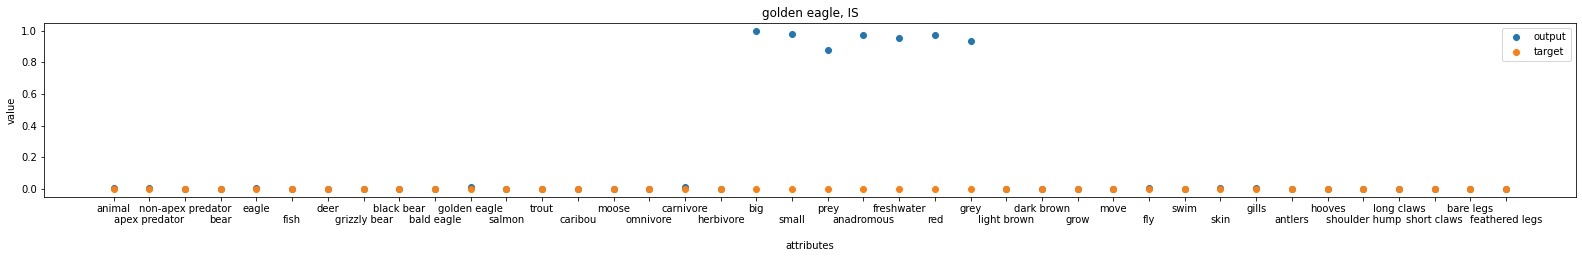

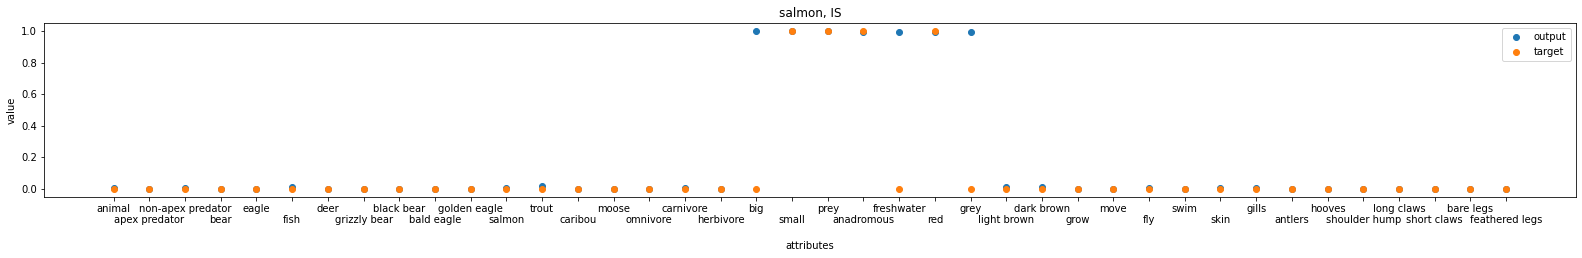

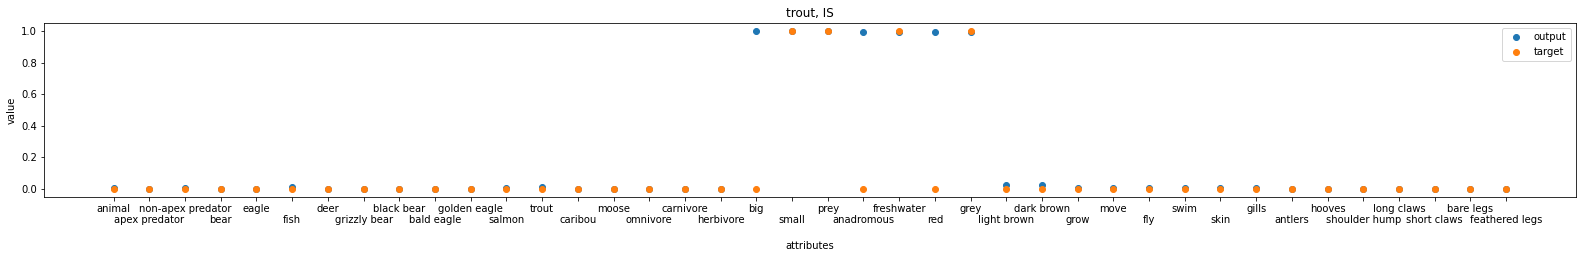

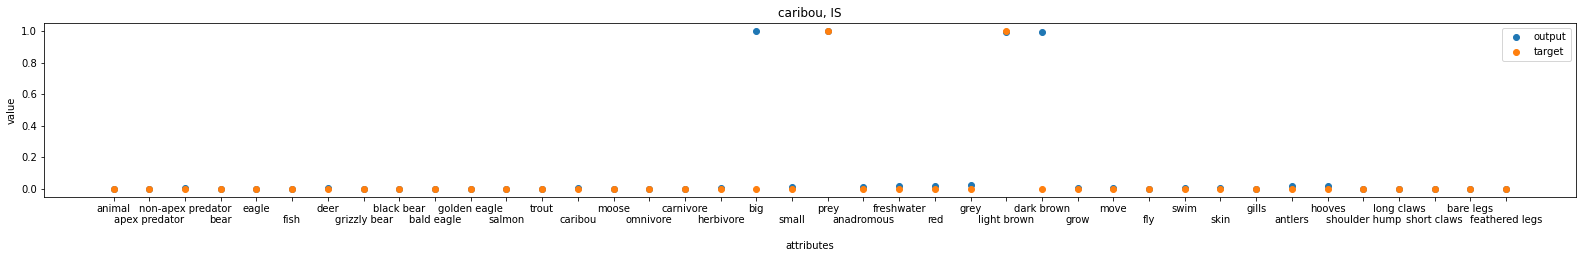

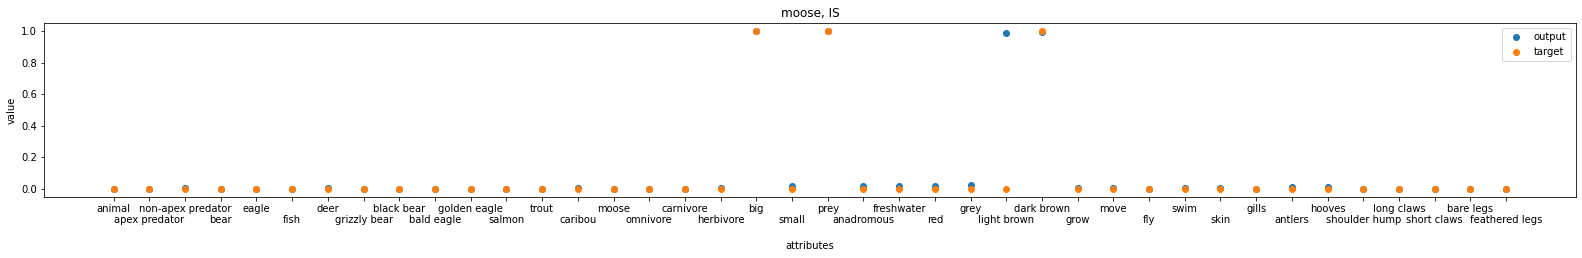

In [16]:
# Display final results (IS) post-training
with torch.no_grad():
  print("Results for {}:".format(relations_list[0]))
  for index, (data, target) in enumerate(relation_DL_order[0]):
    x, y = data
    output = network(data)
    fig, axs = plt.subplots(figsize=(22,3))
    plt.tight_layout()
    labels = [label if i%2==0 else '\n'+label for i,label in enumerate(attributes_list)]
    axs.plot(labels, output.numpy()[0], 'o', label='output')
    axs.plot(labels, target.numpy()[0], 'o', label='target')
    axs.set_xlabel('\nattributes')
    axs.set_ylabel('value')
    axs.set_title(f"{animals_list[index]}, {relations_list[0]}")
    plt.legend();

Results for ISA:


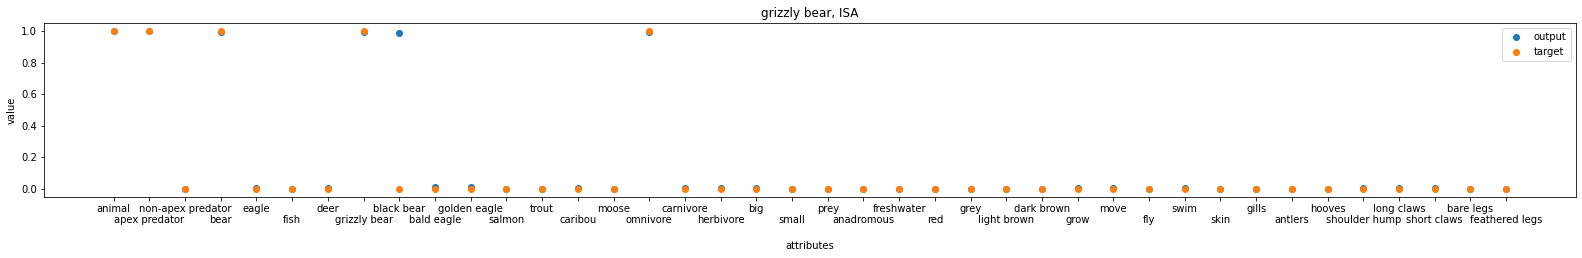

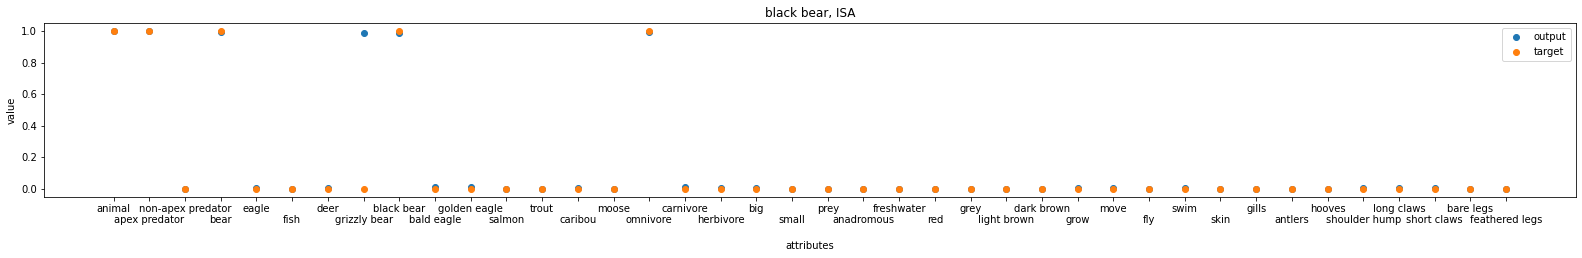

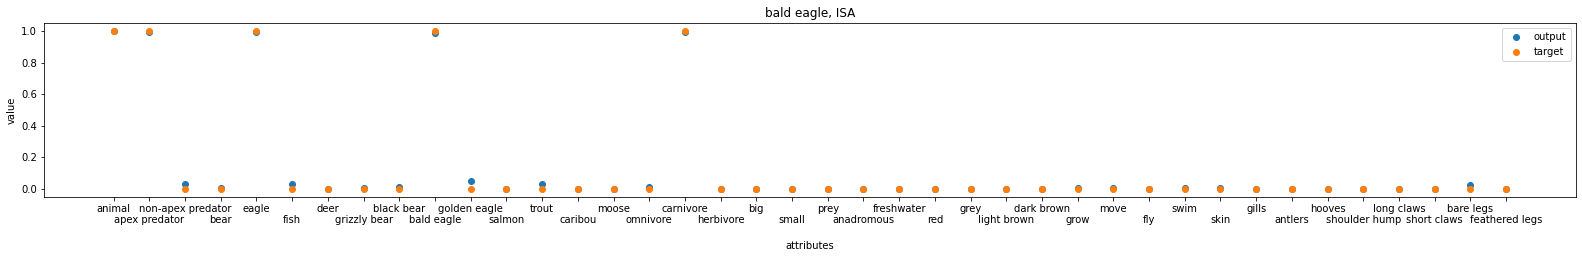

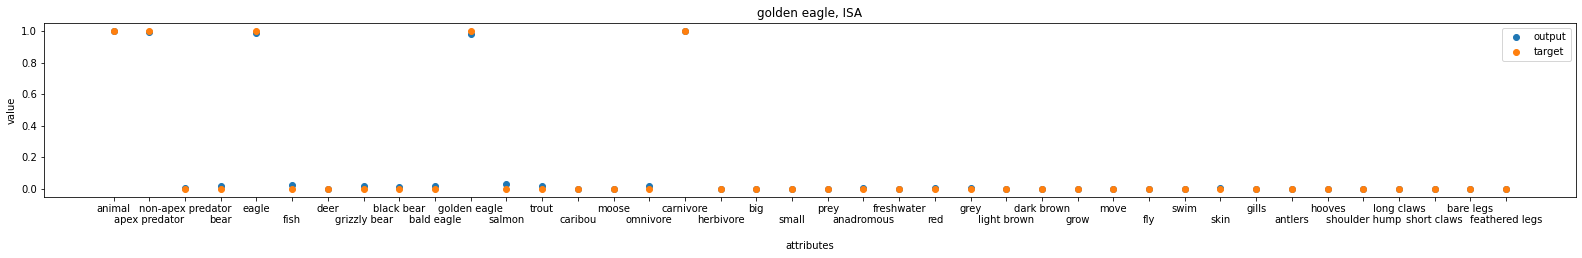

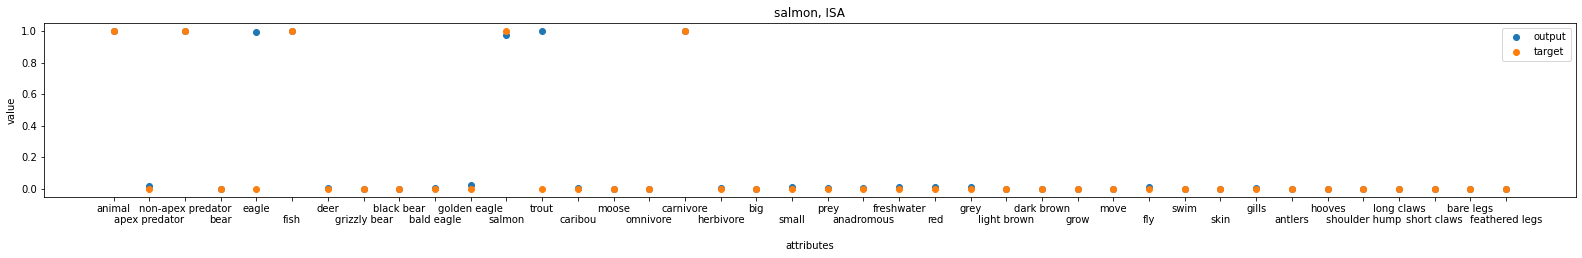

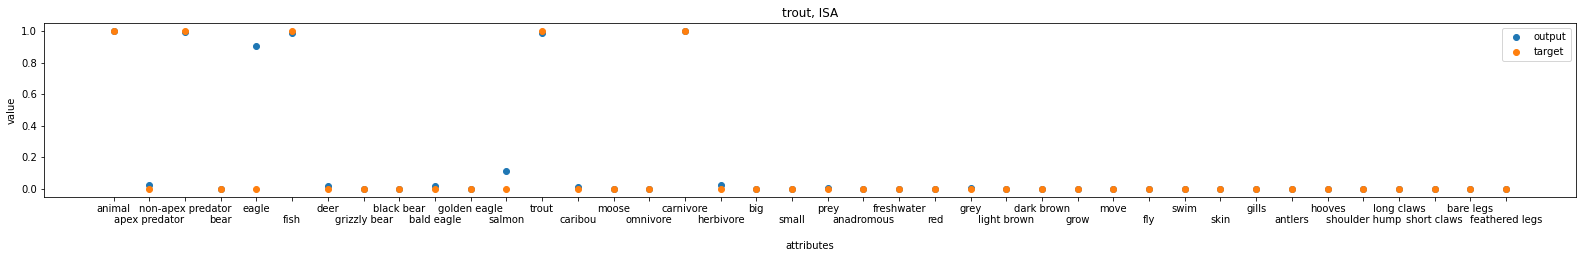

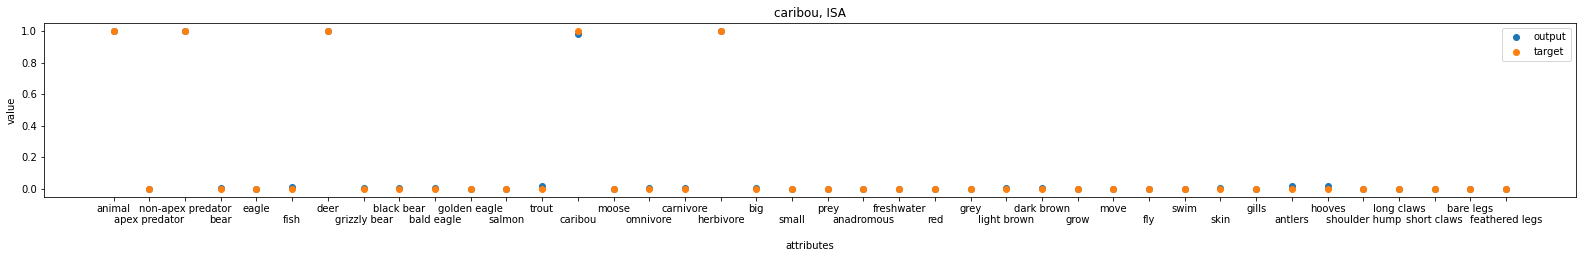

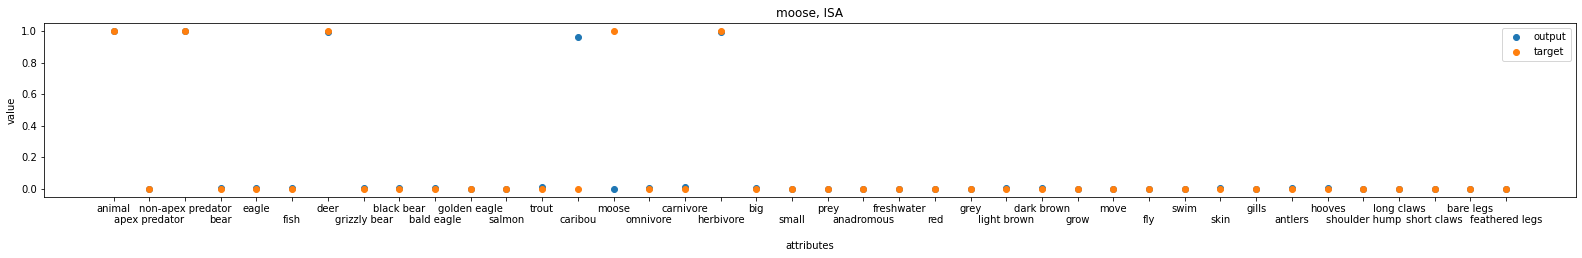

In [17]:
# Display final results (ISA) post-training
with torch.no_grad():
  print("Results for {}:".format(relations_list[1]))
  for index, (data, target) in enumerate(relation_DL_order[1]):
    x, y = data
    output = network(data)
    fig, axs = plt.subplots(figsize=(22,3))
    plt.tight_layout()
    labels = [label if i%2==0 else '\n'+label for i,label in enumerate(attributes_list)]
    axs.plot(labels, output.numpy()[0], 'o', label='output')
    axs.plot(labels, target.numpy()[0], 'o', label='target')
    axs.set_xlabel('\nattributes')
    axs.set_ylabel('value')
    axs.set_title(f"{animals_list[index]}, {relations_list[1]}")
    plt.legend();

Results for CAN:


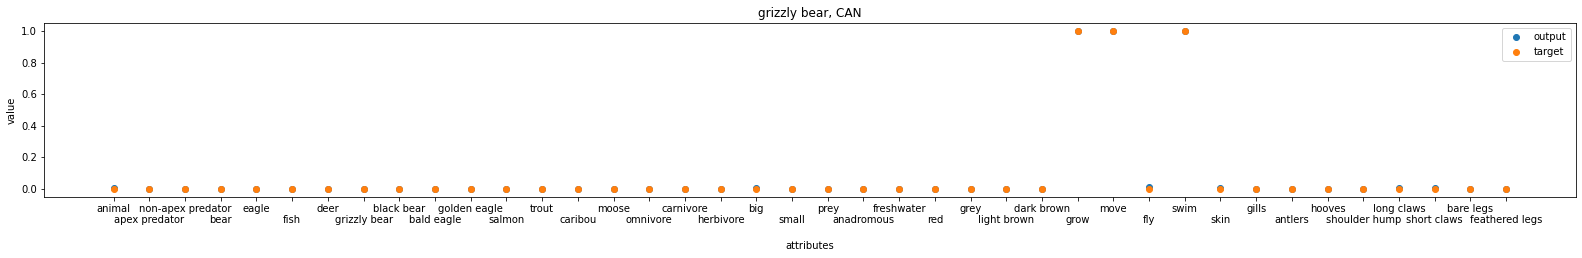

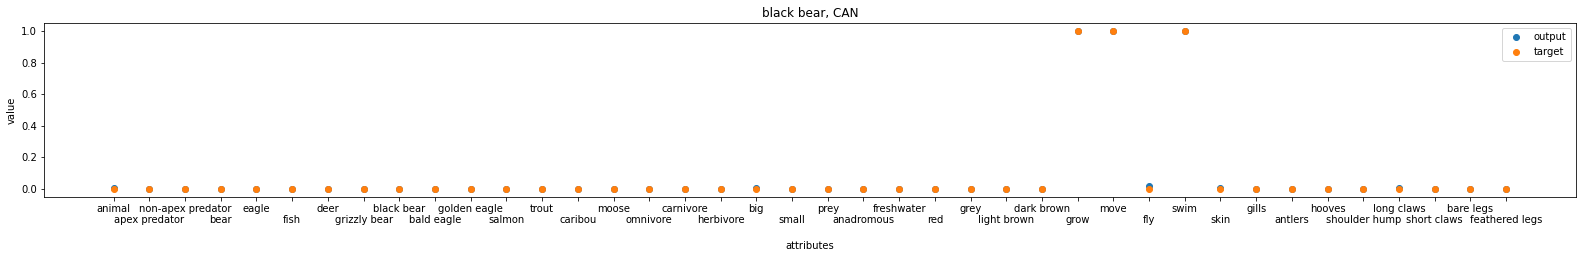

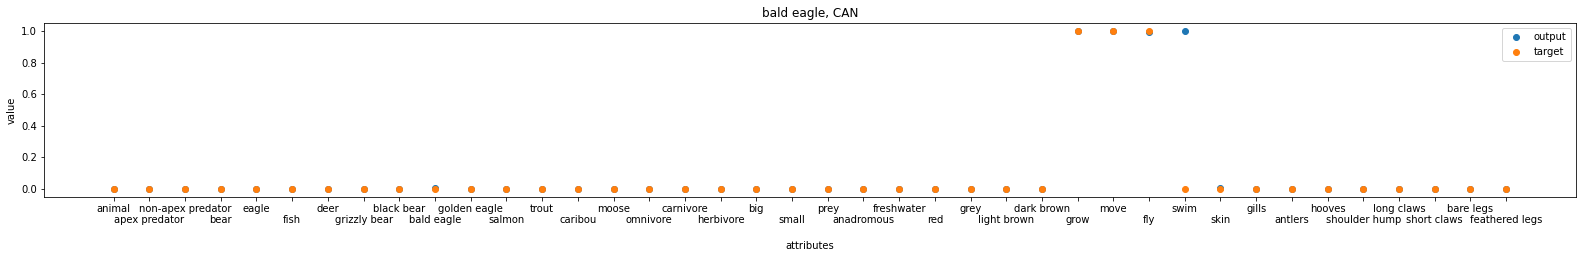

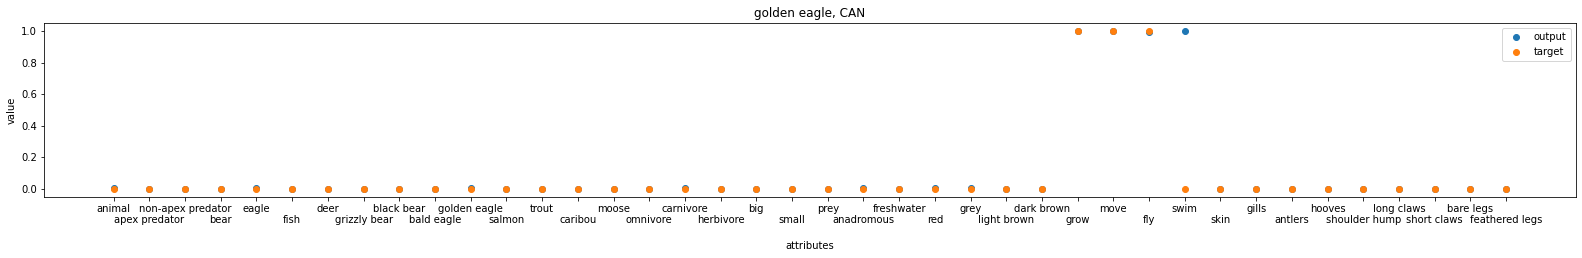

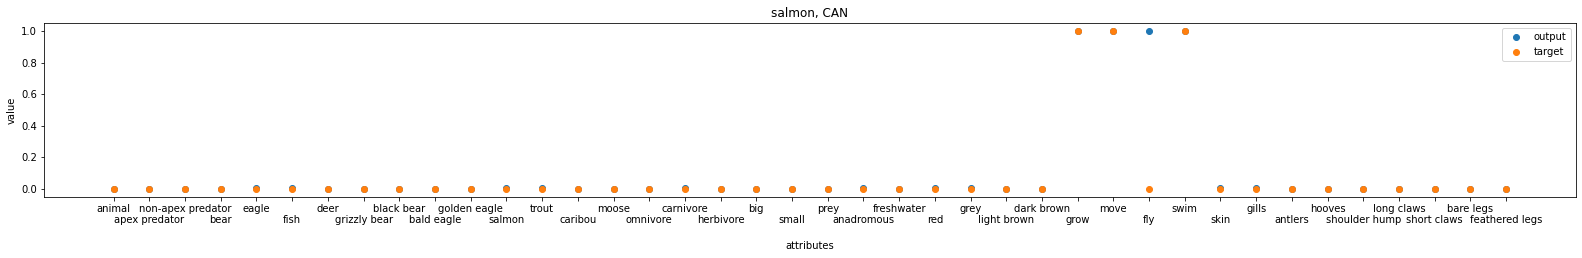

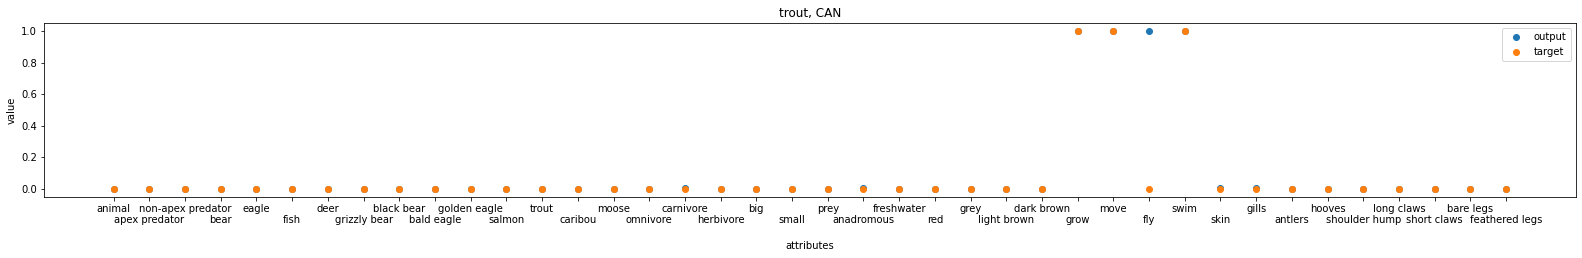

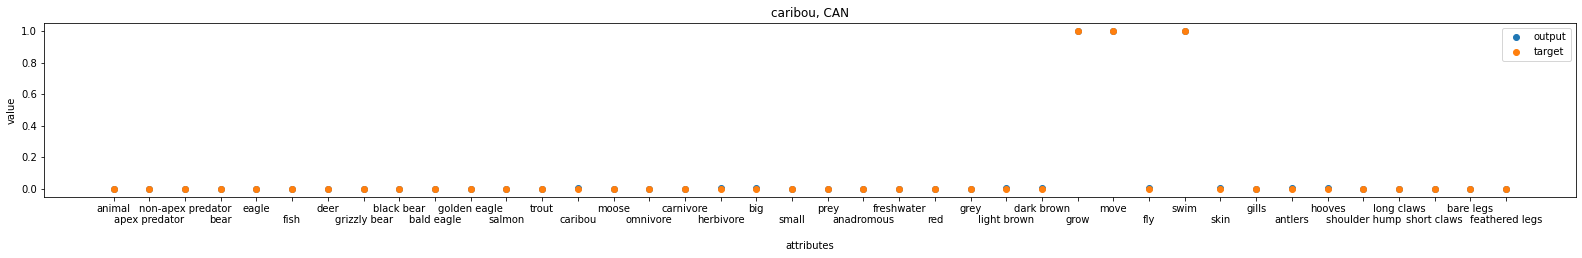

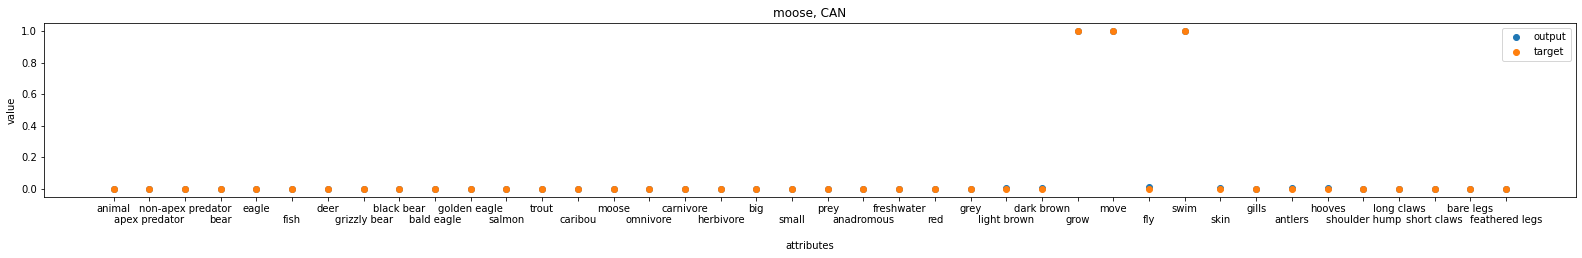

In [18]:
# Display final results (CAN) post-training
with torch.no_grad():
  print("Results for {}:".format(relations_list[2]))
  for index, (data, target) in enumerate(relation_DL_order[2]):
    x, y = data
    output = network(data)
    fig, axs = plt.subplots(figsize=(22,3))
    plt.tight_layout()
    labels = [label if i%2==0 else '\n'+label for i,label in enumerate(attributes_list)]
    axs.plot(labels, output.numpy()[0], 'o', label='output')
    axs.plot(labels, target.numpy()[0], 'o', label='target')
    axs.set_xlabel('\nattributes')
    axs.set_ylabel('value')
    axs.set_title(f"{animals_list[index]}, {relations_list[2]}")
    plt.legend();

Results for HAS:


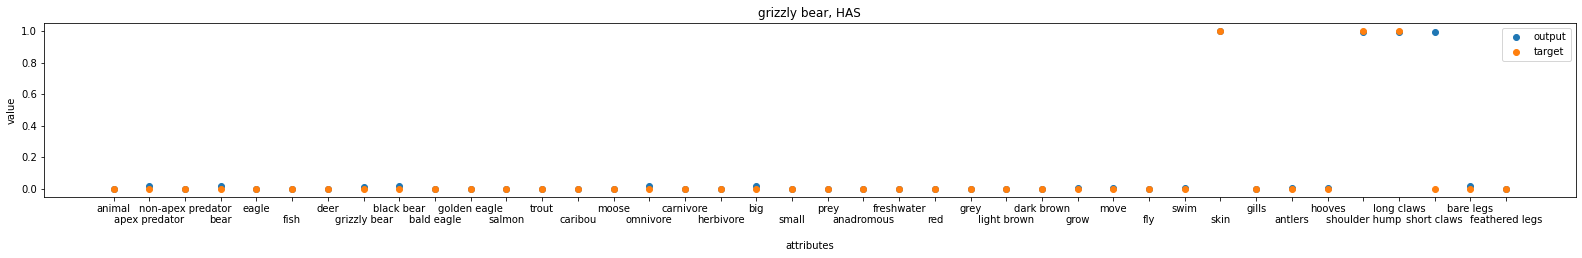

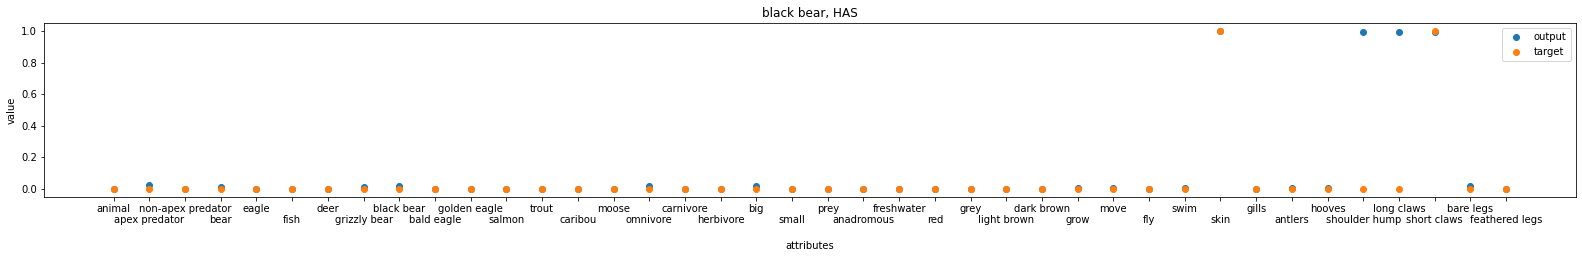

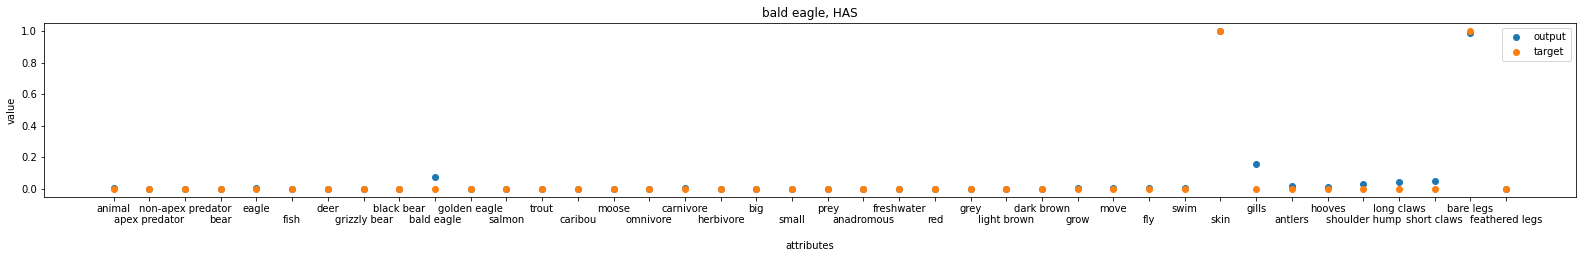

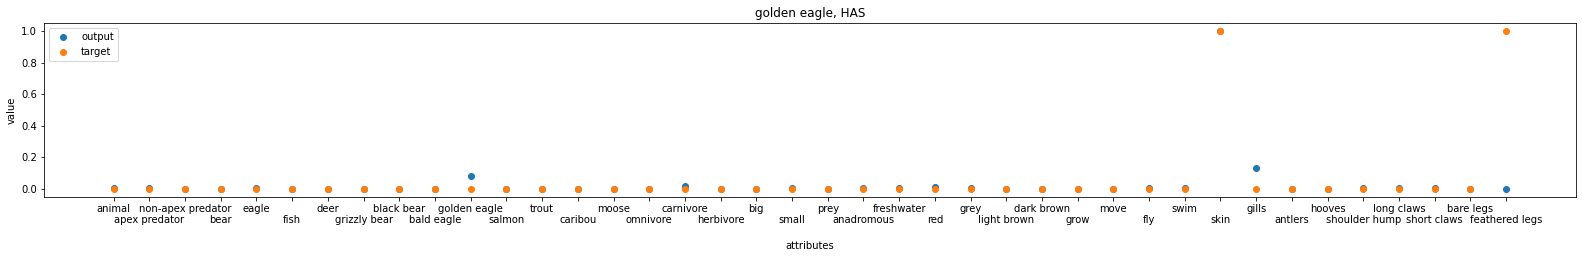

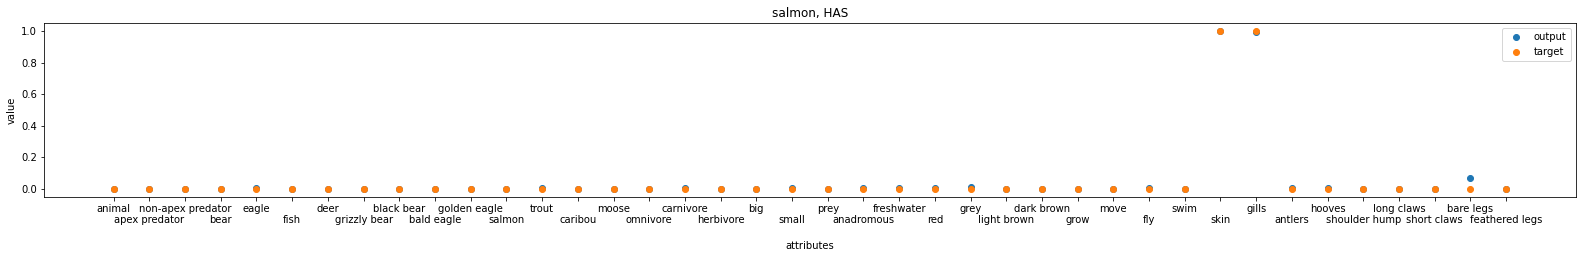

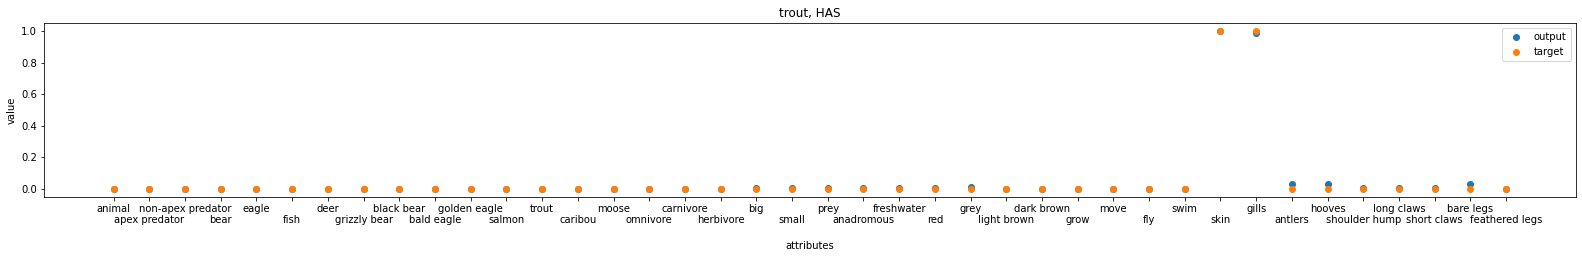

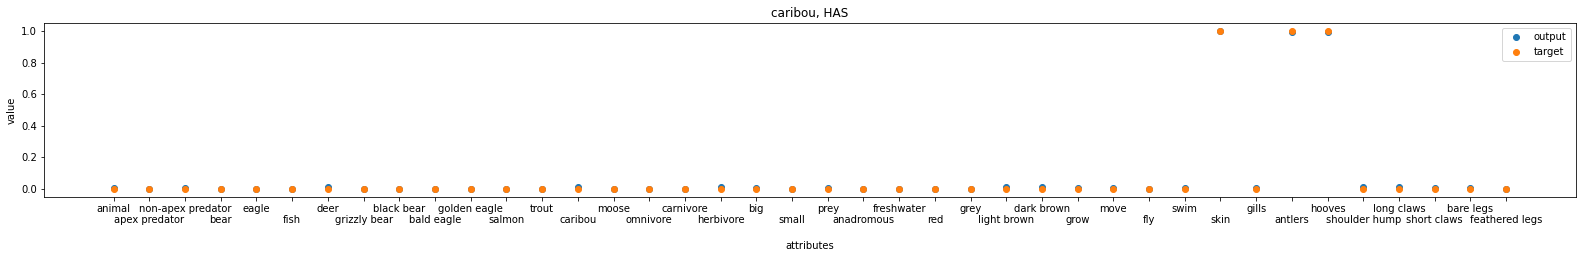

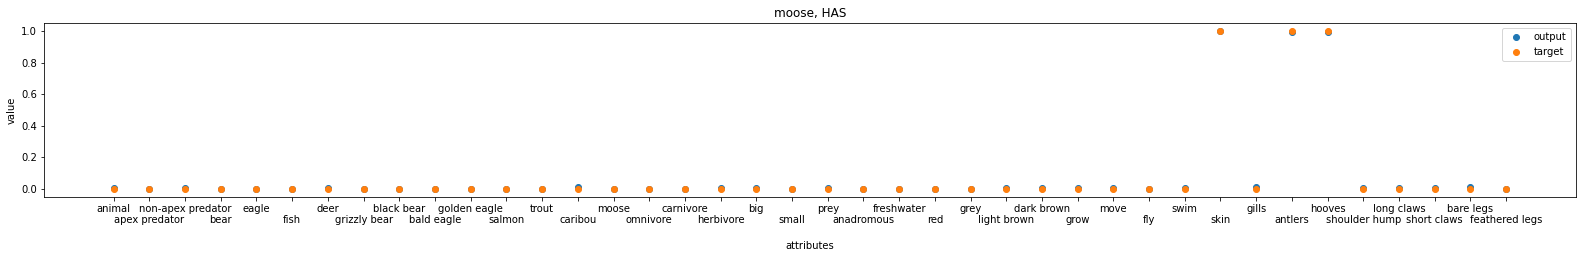

In [19]:
# Display final results (HAS) post-training
with torch.no_grad():
  print("Results for {}:".format(relations_list[3]))
  for index, (data, target) in enumerate(relation_DL_order[3]):
    x, y = data
    output = network(data)
    fig, axs = plt.subplots(figsize=(22,3))
    plt.tight_layout()
    labels = [label if i%2==0 else '\n'+label for i,label in enumerate(attributes_list)]
    axs.plot(labels, output.numpy()[0], 'o', label='output')
    axs.plot(labels, target.numpy()[0], 'o', label='target')
    axs.set_xlabel('\nattributes')
    axs.set_ylabel('value')
    axs.set_title(f"{animals_list[index]}, {relations_list[3]}")
    plt.legend();

# Stage 4: Visualizations

In [30]:
# Import libraries to make dendrograms of animal reps
import scipy.cluster.hierarchy as shc

# Create dataframe of representation values
rep_values_df = pd.DataFrame(np.array(rep_values_list), index=animals_list)
rep_values_df.head(8)

,0,1,2,3,4,5,6,7
grizzly bear,-0.221893,-0.640704,3.039761,-3.635090,0.369143,2.523344,-0.527885,-3.069896
black bear,0.110479,-0.719786,2.740404,-3.223605,1.358622,2.539534,-0.975506,-2.705504
bald eagle,-2.367767,-2.620355,-1.752422,-0.691866,1.166584,2.759173,-2.859699,2.000789
golden eagle,-2.315284,3.022288,-2.258076,0.827435,2.520892,1.024230,-1.913625,-1.478443
salmon,-0.709934,1.835571,-2.776912,2.923208,1.315119,-2.703197,-0.717262,2.074886
trout,0.141069,1.890498,0.742374,2.030044,0.058796,-1.659681,-1.100442,2.169648
caribou,2.786047,-2.954437,2.286486,-0.489088,-1.662341,-0.971522,2.692153,2.584869
moose,2.817247,-2.207570,2.394872,0.916497,-1.270778,0.408718,2.521010,2.089467


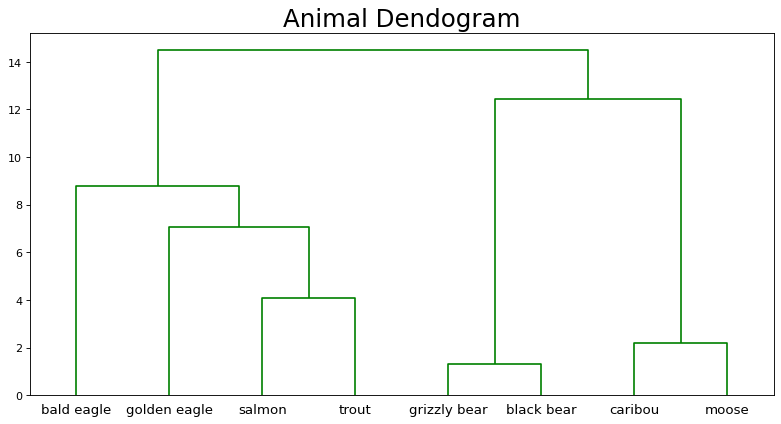

In [31]:
# Create dendogram of animal reps
plt.figure(figsize=(12, 6), dpi= 80)  
plt.title("Animal Dendogram", fontsize=22)
dend = shc.dendrogram(shc.linkage(rep_values_df, method='ward'), 
                      labels=animals_list, color_threshold=100)
plt.xticks(fontsize=12)
plt.show()  